# Imports

In [ ]:
%run base.ipynb
%load_ext autoreload
%autoreload 2

import pickle
from tqdm.notebook import tqdm

import gym
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import scipy.stats as stats 

from abides_gym_custom_execution_environment import SubGymMarketsCustomExecutionEnv
from sigqlearning_qfunctions import SigQFunction
from sigqlearning_test_execution import test
from sigqlearning_train_execution import train
from sigqlearning_baseline_execution import run_baseline
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Environment as gym environment

In [2]:
# register execution env for gym use 
from gym.envs.registration import register

register(
    id="custom-execution-v0",
    entry_point=SubGymMarketsCustomExecutionEnv,
)

In [3]:
# helper function to generate environment with specified parameters
def generate_env(seed=None, **env_params):
    """
    generates specific environment with the parameters defined and set the seed
    """
    env = gym.make(id = "custom-execution-v0", **env_params)
    if seed is not None:
        env.seed(seed)
    return env

In [4]:
# environment parameters
env_params = dict(
    background_config = "rmsc04",
    mkt_close = "10:05:00",
    timestep_duration = "10s",
    first_interval = "00:05:00",
    observation_interval = "00:00:00",            
    order_fixed_size = 50,
    max_inventory = 1000,
    starting_inventory = 700,
    terminal_inventory_reward = -0.7, # reward or penalty
    terminal_inventory_mode = 'quadratic', # quadratic, linear, flat
    running_inventory_reward_dampener = 0., # 0.6, 1.0
    damp_mode = None, # asymmetric
    debug_mode = False,
    reward_multiplier = 'quadratic_positive', # running reward mode
    reward_multiplier_float = None, #1.5,
)

# Baseline policy

The baseline policy sells its inventory as long as the absolute inventory value is above 5% of the maximal inventory and afterwards stops trading until the end of the episode. It is exactly the policy the RL agent is supposed to learn and offers a baseline reward to compare it against.

In [ ]:
# run baseline
env = generate_env(1000, **env_params) # seed different from any test run seed
baseline_results_dict = run_baseline(env, episodes=2000)

In [5]:
save_load_baseline = 'load'
date_time_id = '20250127_A_2000_episodes'

# save or load
if save_load_baseline == 'save':
    file_path = '../results/custom_execution_baseline_results_{}_NEW.pkl'.format(date_time_id)
    with open(file_path, 'wb') as fout:  
        pickle.dump(baseline_results_dict, fout)
    print(f"***** baseline results SAVED under {file_path} *****")

if save_load_baseline == 'load':
    file_path = '../results/custom_execution_baseline_results_{}.pkl'.format(date_time_id)
    with open(file_path, 'rb') as fin:        
        baseline_results_dict = pickle.load(fin)
        print(f"***** baseline results LOADED from {file_path} *****")

***** baseline results LOADED from ../results/custom_execution_baseline_results_20250127_A_2000_episodes.pkl *****


## Baseline statistics 

In [6]:
baseline_stats = []
baseline_stats.append(np.mean(baseline_results_dict['rewards'])) # mean reward
baseline_stats.append(np.std(baseline_results_dict['rewards'])) # std reward
baseline_stats.append(np.median(baseline_results_dict['rewards'])) # median reward
baseline_stats.append(np.mean(baseline_results_dict['terminal_inventories'])) # mean terminal inventory
baseline_stats.append(np.std(baseline_results_dict['terminal_inventories'])) # std terminal inventory
baseline_stats.append(int(np.min(baseline_results_dict['terminal_inventories']))) # min terminal inventory
baseline_stats.append(int(np.max(baseline_results_dict['terminal_inventories']))) # max terminal inventory
    
columns = [
    'Mean\nreward', 'Std\nreward', 'Median\nreward', 'Mean terminal\ninventory', 
    'Std terminal\ninventory', 'Min terminal\ninventory', 'Max terminal\ninventory' 
]
print(tabulate([baseline_stats], headers=columns, tablefmt='fancy_grid', floatfmt='.5f'))

╒══════════╤══════════╤══════════╤═════════════════╤════════════════╤════════════════╤════════════════╕
│     Mean │      Std │   Median │   Mean terminal │   Std terminal │   Min terminal │   Max terminal │
│   reward │   reward │   reward │       inventory │      inventory │      inventory │      inventory │
╞══════════╪══════════╪══════════╪═════════════════╪════════════════╪════════════════╪════════════════╡
│ -0.08440 │  0.07359 │ -0.06188 │        -0.21650 │       13.09514 │            -24 │             25 │
╘══════════╧══════════╧══════════╧═════════════════╧════════════════╧════════════════╧════════════════╛


## Baseline plots

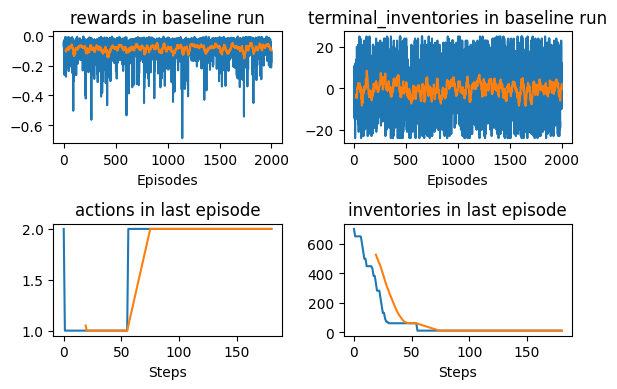

In [8]:
episode_id = -1
utils.plot_baseline_results(baseline_results_dict, episode_id, ma_window=20, figsize=(6, 4))

save_baseline_plot = False
if save_baseline_plot:
    utils.save_baseline_trajectories(baseline_results_dict, episode_ids=[-6, -9], show=True, file_path="../figures/")

## Confidence interval baseline rewards

We inspect the distribution of rewards from the baseline run and find that it is moderately right-skewed. We then compute confidence intervals for the mean reward using three different methods: 
1. Normal-based CI (Large Sample Theory),   
2. Bootstrap CI,
3. Log-Transformed CI.

The log-transformed CI is computed by fitting a lognormal distribution to the negative rewards and following the approach for confidence intervals for three parameter log-normal distrobutions in Olsson (2017). The obtained CI are then transformed back to the original scale. The bootstrap CI is obtained by resampling the rewards with replacement and computing the mean of each sample.

In [ ]:
baseline_rewards = np.array(baseline_results_dict['rewards'])

# histogram and boxplot
fig, axs = plt.subplots(1, 2, figsize=(11,3.5))
axs[0].hist(baseline_rewards, bins=80, color='skyblue', edgecolor='black', alpha=0.7)
axs[0].set_title('Baseline rewards histogram', fontsize=11)
axs[0].set_xlabel('Rewards')
axs[0].set_ylabel('Frequency')
bp = axs[1].boxplot(baseline_rewards, showmeans=True, meanline=True, patch_artist=True, 
                    boxprops=dict(facecolor="white"))
axs[1].legend([bp['means'][0], bp['medians'][0], bp['boxes'][0], bp['whiskers'][0]], 
              ['mean', 'median', 'IQR', r'$\pm$1.5 IQR'], loc='lower right')
axs[1].set_ylabel('Rewards')
axs[1].set_xticks([1], [])
axs[1].set_title('Baseline rewards boxplot', fontsize=11)
plt.show()

In [ ]:
baseline_rewards = np.array(baseline_results_dict['rewards']) # Ensure the data is a NumPy array

alpha = 0.05 # significance level 1 - alpha
n = len(baseline_rewards)
t_critical = stats.t.ppf(1 - alpha / 2, df=n-1)  # 95% confidence level

# compute skewness
sample_skewness = stats.skew(baseline_rewards)
print('Reward distribution skewness:', round(sample_skewness, 5))

# 1. Normal-based CI (Large Sample Theory)
sample_mean = np.mean(baseline_rewards)
sample_std = np.std(baseline_rewards, ddof=1)
print('standard error:', sample_std / np.sqrt(n))

normal_CI = (sample_mean - t_critical * sample_std / np.sqrt(n), 
             sample_mean + t_critical * sample_std / np.sqrt(n))

# 2. Bootstrap CI
np.random.seed(1) 
bootstrap_samples = np.random.choice(baseline_rewards, size=(1000, n), replace=True)
bootstrap_means = np.mean(bootstrap_samples, axis=1)
bootstrap_CI = np.percentile(bootstrap_means, [2.5, 97.5])

# 3. Log-Transformed CI
shape, loc, scale = stats.lognorm.fit(-baseline_rewards, loc=0.0)
stdized_rewards = (np.log(-baseline_rewards - loc) - np.log(scale)) / shape
fitted_mean = np.log(scale) # mean of (- rewards - loc), lognormal with loc=0
fitted_std_estimate = np.sqrt(shape ** 2 / n + shape ** 4 / (2*(n - 1))) # based on Olsson paper

lognorm_CI = (np.exp(fitted_mean + shape ** 2 / 2 - t_critical * fitted_std_estimate), 
              np.exp(fitted_mean + shape ** 2 / 2 + t_critical * fitted_std_estimate))
lognorm_CI = (-lognorm_CI[1] - loc, -lognorm_CI[0] - loc)

# print results
lognorm_params = np.array([shape, loc, scale])
print(tabulate([lognorm_params], headers=['shape', 'loc', 'scale'], showindex=['lognormal fit'],
               tablefmt='fancy_grid', floatfmt='.5f'))

CI_results = [normal_CI, lognorm_CI, bootstrap_CI]
print(tabulate(CI_results, headers=[f'{int(100*(1-alpha))}% Confidence intervals', 'lower bound', 'upper bound'], 
               showindex=['normal CI', 'lognormal CI', 'bootstrap CI'], tablefmt='fancy_grid', floatfmt='.6f'))

# Training

## Training parameters

In [5]:
# signature parameters
sigq_params = dict(
    sig_depth = 7,
    basepoint = [0., 0.], 
    initial_bias = 0.01,
)

# training parameter
training_params = dict(
    episodes = 3000,
    discount = 1.0,
    learning_rate = 5*1e-5,
    learning_rate_decay = dict(mode='exponential', factor=0.999),
        #dict(mode=None),
        #dict(mode='linear', end_value=1e-7, epochs=2000), 
    exploration = 'greedy',
    epsilon = 1,
    epsilon_decay = dict(mode='exponential', factor=0.997),
        #dict(mode=None),
        #dict(mode='linear', end_value=0.02, epochs=1000),  
    decay_mode = 'episodes',
    debug_mode = None,
    progress_display = 'livelossplot',
)

## Learn a Q-function estimate
Learn a Q-function estimate with Signature-Q-learning. We run 5 different seeds.

**Note**: This code cell takes a long time to run. Would recommend to copy this cell in a python script and let it run in the back with [screen](https://linuxize.com/post/how-to-use-linux-screen/) or [tmux](https://www.hamvocke.com/blog/a-quick-and-easy-guide-to-tmux/) for instance. 

In [ ]:
# number of training runs
n_runs = 10

# dict to store results
training_results_dict = {run : [] for run in range(n_runs)}
training_seeds = {
    run : seed for run, seed 
    in zip(training_results_dict, utils.generate_prime_seeds(n_runs, random=True))
}

final_Q_functions = {}

# training runs
runs_pbar = tqdm(training_results_dict.keys(), desc='Training runs')
for run in runs_pbar:
    env = generate_env(training_seeds[run], **env_params)
    sigqfunction = SigQFunction(env, **sigq_params)
    training_results_dict[run] = train(env, sigqfunction, **training_params)
    final_Q_functions[run] = sigqfunction.state_dict()

## Save training results

**Note**: Training results are saved under `../results/file_name + today + id`, where `today` is the current date
in the form `%Y%M%d` and `id` an upper case letter to identifiy multiple files saved on the same date.

In [ ]:
file_name = "custom_execution_training"
results_dict=dict(training_results=training_results_dict, final_Q_functions=final_Q_functions,
                  sig_params=sigq_params, training_params=training_params, env_params=env_params,
                  training_seeds=training_seeds)
date_time_id = utils.save_results(results_dict, file_name)

## Training plots

### Single training run

In [ ]:
# select training run number for plotting
run_id = 3
start = -2000
end = -1
utils.plot_training_run_results(training_results_dict, run_id, figsize=None)
plt.plot(training_results_dict[run_id]['terminal_inventory'][start:end])
plt.plot([0 for _ in range(end - start)], color='black')
plt.plot([100 for _ in range(end - start)], color='black')
plt.plot([-100 for _ in range(end - start)], color='black')
plt.show()

### Averaged training results

And save each plot as single file in `..\figures`. Each file name contains `date_time_id` of the corresponding file containing saved training results.

In [ ]:
save_plots = False
if save_plots: 
    utils.save_mean_training_results_plots(training_results_dict, date_time_id=date_time_id, 
                                           file_name='custom_execution', show=False)

utils.plot_mean_training_results(training_results_dict, figsize=None)

### Observation-action histories

To gain a more qualitative insight into the policies based on the learned Q-functions, we plot the observation and action trajectories of specific training episodes.

In [ ]:
run_ids = 'all'
episode_ids = [0, 999, 1999, 2999] 
utils.plot_inventory_action_histories(training_results_dict, run_ids, episode_ids)

### First observation value convergence

**Note**: We need to compare trajectory of the first observation value as provided by the Q-function approximations during training, with the average episode reward once all runs are performed. If the reward and the first observation value converge towards the same value, this is an indication that the algorithm has converged. Note, however, that this does not necessariliy mean that the Q-function approximation has converged to the true optimal Q-functions.

In [ ]:
utils.plot_first_observation_values(training_results_dict, run_ids='all', mean=True, 
                                    std=True, figsize=(8,3.2), line=-0.0844,
                                    save=True, date_time_id='20250127_A')

In [ ]:
utils.plot_reward_vs_first_obs_value(training_results_dict, episode_window=(-1000,-1), 
                                     figsize=(8,3), line=-0.0844,
                                     save=True, date_time_id='20250127_A')

# Testing

To load prior saved training results, set `load_training_results_flag` to True and paste trainings results' file name.

In [ ]:
load_training_results_flag = True
from pprint import pp as pprint

if load_training_results_flag:
    date_time_id = '20250127_A'
    file_path = '../results/custom_execution_training_{}.pkl'.format(date_time_id)
    # load training results
    with open(file_path, 'rb') as fin:        
        loaded_training_dict = pickle.load(fin)

    env_params = loaded_training_dict["env_params"]
    sigq_params = loaded_training_dict["sig_params"]
    training_params = loaded_training_dict["training_params"]
    training_results_dict = loaded_training_dict["training_results"]
    final_Q_functions = loaded_training_dict["final_Q_functions"]
    training_seeds = loaded_training_dict["training_seeds"]
    n_runs = len(training_results_dict)

    print("***** training results {} loaded *****".format(date_time_id))
    print('Performed training runs: {}. With parameters:\n'.format(n_runs))
    pprint({key: value for key, value in loaded_training_dict.items() if key not in ('training_results', 'final_Q_functions')})
    del loaded_training_dict

## Test a Q-function estimate

We test the Q-functions learning in training. If an intermediate Q-function estimate saved at some checkpoint instead of the last one for each training run should be tested, set `checkpoint_policy_flag` to True and select a checkpoint.

In [ ]:
checkpoint = -1 # final

n_test_episodes = 2000
test_results_dict = {}
test_seeds = utils.generate_prime_seeds(100, random=True)

runs_pbar = tqdm(training_results_dict.keys(), desc='Test runs')
for run in runs_pbar:
    env = generate_env(test_seeds[run], **env_params)
    sigqfunction = SigQFunction(env, **sigq_params)
    q_state_dict = final_Q_functions[run] if checkpoint == 'final' \
        else training_results_dict[run]["intermediate"][checkpoint]
    sigqfunction.load_state_dict(q_state_dict)
    test_results_dict[run] = test(env, sigqfunction, n_test_episodes, debug_mode="info")

## Save/load test results

In [40]:
save_or_load_flag = 'load'
date_time_id = '20250127_A_@3000_for_2000'

if save_or_load_flag == 'save':
    file_path = '../results/custom_execution_test_results_{}.pkl'.format(date_time_id)
    with open(file_path, 'wb') as fout:  
        pickle.dump((test_results_dict, test_seeds), fout)
    print(f"***** test results SAVED under {file_path} *****")

if save_or_load_flag == 'load':
    file_path = '../results/custom_execution_test_results_{}.pkl'.format(date_time_id)
    with open(file_path, 'rb') as fin:       
        test_results_dict, test_seeds = pickle.load(fin)
        #test_results_dict = pickle.load(fin)
        print(f"***** test results LOADED from {file_path} *****")

***** test results LOADED from ../results/custom_execution_test_results_20250127_A_@3000_for_2000.pkl *****


## Test statistics

The following statistics are reported for each test run:
- Mean reward and standard deviation
- Mean terminal inventory and standard deviation
- Minimum / maximum inventory in test run
- Mean terminal cash and standard deviation
- First observation value

In [11]:
test_stats = []
rho = 50
for test_run in test_results_dict.values():
    run_stats = []
    run_stats.append(np.mean(test_run['rewards'])) # mean reward
    run_stats.append(np.std(test_run['rewards'])) # std reward
    run_stats.append(np.median(test_run['rewards'])) # median reward
    run_stats.append(np.mean(test_run['terminal_inventories'])) # mean terminal inventory
    run_stats.append(np.std(test_run['terminal_inventories'])) # std terminal inventory
    run_stats.append(int(np.min(test_run['terminal_inventories']))) # min terminal inventory
    run_stats.append(int(np.max(test_run['terminal_inventories']))) # max terminal inventory
    run_stats.append(sum(abs(np.array(test_run['terminal_inventories'])) <= rho//2) / 
                     len(test_run['terminal_inventories']) ) # pct in [-rho/2, rho/2]
    run_stats.append(sum(abs(np.array(test_run['terminal_inventories'])) <= rho) / 
                     len(test_run['terminal_inventories']) ) # pct in [-rho, rho]
    run_stats.append(test_run['first_obs_values'][-1]) # first observation value
    test_stats.append(run_stats)

columns = ['\nRun', 'Mean\nreward', 'Std\nreward', 'Median\nreward','Mean terminal\ninventory', 
           'Std terminal\ninventory', 'Min terminal\ninventory', 'Max terminal\ninventory', 
           'Pct in\n[-rho/2,rho/2]', 'Pct in\n[-rho,rho]', 'First obs\nvalue']
print(tabulate(test_stats, headers=columns, showindex=test_results_dict.keys(),tablefmt='simple', floatfmt='.5f'))
print('mean of mean rewards:', round(np.mean([run_stats[0] for run_stats in test_stats]), 5))
print('mean of median rewards:', round(np.mean([run_stats[2] for run_stats in test_stats]), 5))

           Mean       Std    Median    Mean terminal    Std terminal    Min terminal    Max terminal            Pct in        Pct in    First obs
  Run    reward    reward    reward        inventory       inventory       inventory       inventory    [-rho/2,rho/2]    [-rho,rho]        value
-----  --------  --------  --------  ---------------  --------------  --------------  --------------  ----------------  ------------  -----------
    0  -0.09290   0.08177  -0.06769         37.52100        43.35821             -76             501           0.34900       0.75550     -0.08817
    1  -0.09323   0.09122  -0.06439         13.01350        43.98486            -257             110           0.41600       0.80500     -0.08194
    2  -0.09392   0.08452  -0.06847         37.89550        38.51388             -51             164           0.41850       0.68200     -0.08479
    3  -0.08628   0.07814  -0.06092        -13.90050        29.35651            -123             132           0.65350      

## Test plots

### Single test run and episode

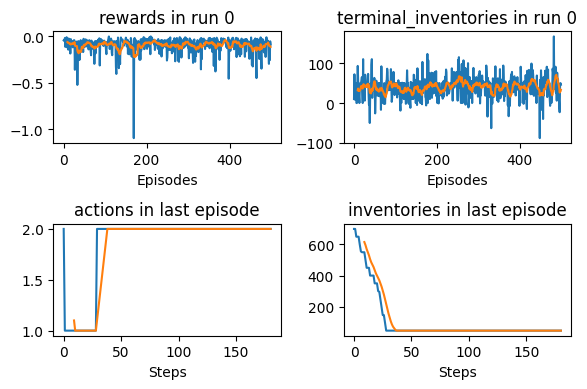

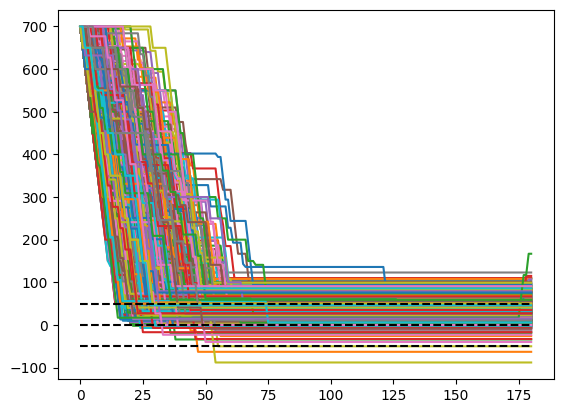

In [91]:
run_id = 0
episode_id = -1
utils.plot_test_run_results(test_results_dict, run_id, episode_id, 
                            ma_window=10, figsize=(6, 4))

for episode in test_results_dict[run_id]['inventories']:
    plt.plot(episode)
n_steps = 181
plt.plot([50 for _ in range(n_steps)], color='black', linestyle='--')
plt.plot([-50 for _ in range(n_steps)], color='black', linestyle='--')
plt.plot([0 for _ in range(n_steps)], color='black', linestyle='--')
plt.show()

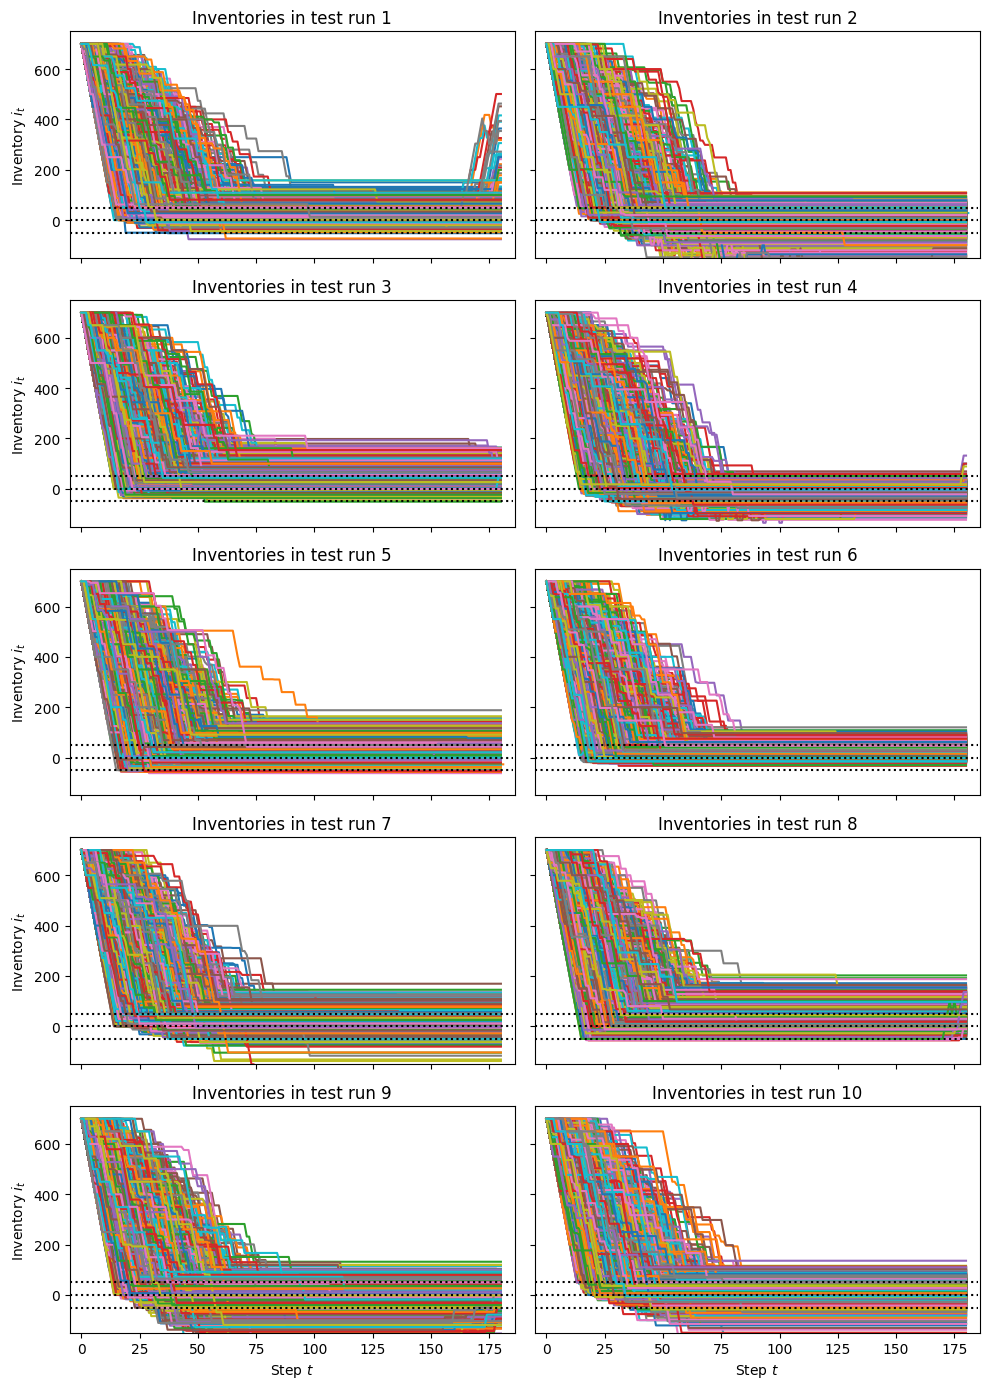

In [ ]:
# trajectories of inventories for all test runs
runs = list(range(10)) #[0, 1]
n_steps = 181
domain = range(-5, n_steps + 5)
fig, axs = plt.subplots(5, 2, figsize=(10, 14), sharey=True, sharex=True)
for ax, id_x in zip(axs.flatten(), runs):
    for episode in test_results_dict[id_x]['inventories']:
        ax.plot(episode)
    for value in [-50, 0, 50]:
        ax.plot(domain, [value for _ in domain], c='black', ls=':', lw=1.5)
    ax.set_xlim(-5, n_steps + 5)
    ax.set_ylim(-150, 750)
    ax.set_title(f'Inventories in test run {id_x+1}') # for plotting + 1
    if id_x % 2 == 0:
        ax.set_ylabel(r'Inventory $i_t$')
    if id_x in runs[-2:]:
        ax.set_xlabel(r'Step $t$')
fig.tight_layout()
plt.show()

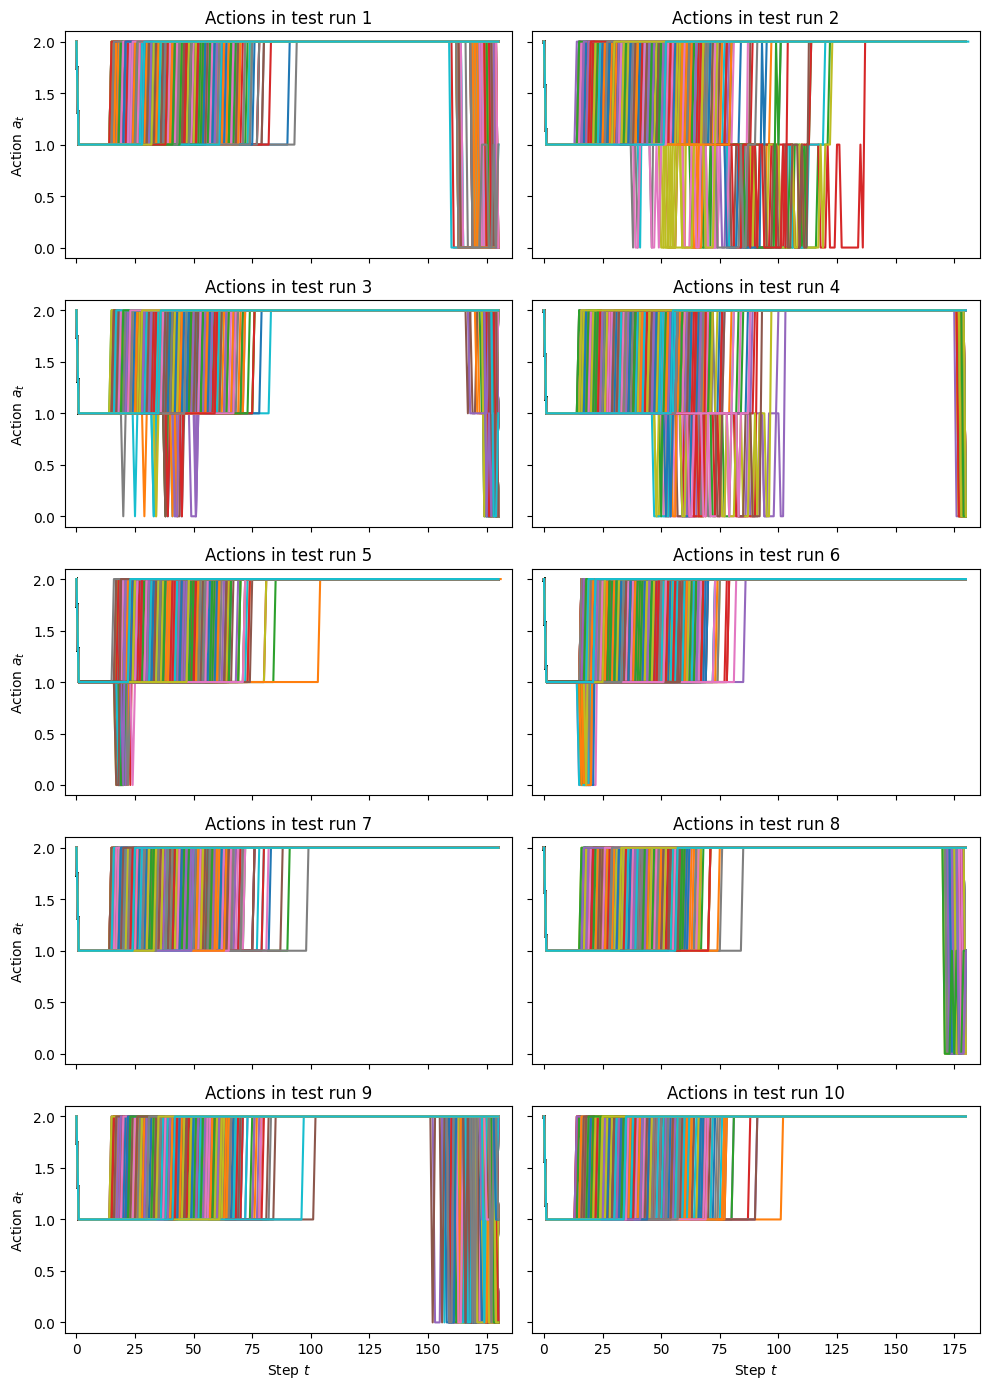

In [ ]:
# trajectories of actions for all test runs
runs = list(range(10)) #[8, 9]
n_steps = 181
domain = range(-5, n_steps + 5)
fig, axs = plt.subplots(5, 2, figsize=(10, 14), sharey=True, sharex=True)
for ax, id_x in zip(axs.flatten(), runs):
    for episode in test_results_dict[id_x]['actions']:
        ax.plot(episode)
    ax.set_xlim(-5, n_steps + 5)
    ax.set_title(f'Actions in test run {id_x+1}') # for plotting + 1
    if id_x % 2 == 0:
        ax.set_ylabel(r'Action $a_t$')
    if id_x in runs[-2:]:
        ax.set_xlabel(r'Step $t$')
fig.tight_layout()
plt.show()

### Box-plot of rewards

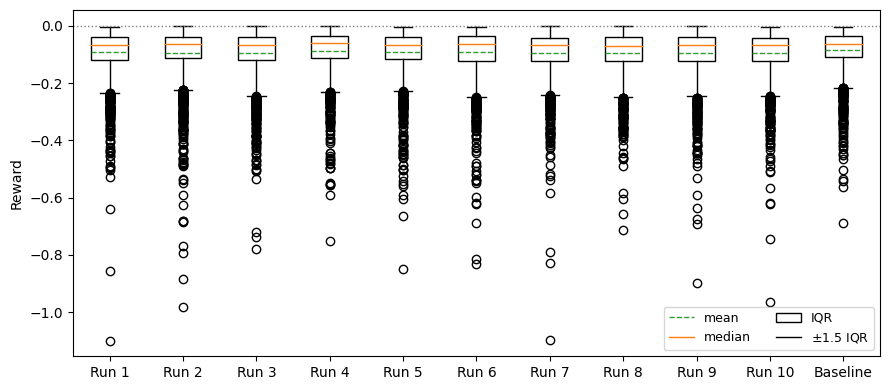

In [11]:
save_figure = 0

all_rewards = [run['rewards'] for run in test_results_dict.values()]
all_rewards.append(baseline_results_dict['rewards'])
plt.figure(figsize=(9, 4))
bp = plt.boxplot(all_rewards, showmeans=True, meanline=True, patch_artist=True, 
                    boxprops=dict(facecolor="white"),)# flierprops=dict(marker='o', markersize=5),)
plt.plot([i for i in range(len(all_rewards)+2)], [0 for _ in range(len(all_rewards)+2)], 
         color='grey', ls=':', lw=1)
plt.legend([bp['means'][0], bp['medians'][0], bp['boxes'][0], bp['whiskers'][0]], 
              ['mean', 'median', 'IQR', r'$\pm$1.5 IQR'], loc='lower right', fontsize=9, ncol=2)

plt.xlim(0.5, len(all_rewards)+0.5)
plt.xticks(range(1, len(all_rewards)+1), ['Run {}'.format(i) for i in range(1, len(all_rewards))] + ['Baseline'])
plt.ylabel('Reward')
plt.tight_layout()
if save_figure:
    plt.savefig(f'../figures/testing_boxplot_all_rewards_{date_time_id}')
plt.show()

# Baseline log-normal fit

We inspect the log-normal fit by visual means. No statistical goodness-of-fit test is performed, however, one could transform the data with the fitted paramters to the normal scale and test for normality with e.g. Anderson-Darling, Shapiro-Wilk, Jarque-Bera test.
Note, that performing these tests with parameters fitted from the data changes the test value's dsitrbution under the null and p-values might be meaningless. 

Alternatively, parametric bootstrapping could be performed with a chosen test, to obtain the empirical distribution of the test value under the null distribution with the fitted parameters.

In [ ]:
# visual inspection of log-normal fit
samples = stats.lognorm.rvs(shape, loc, scale, size=n)
stdzd_samples = (np.log(samples - loc) - np.log(scale)) / shape

plt.figure(figsize=(12,8))    
plt.boxplot([-baseline_rewards, samples], labels=['negative baseline rewards', 'log-normal samples'])
plt.legend()
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(12,9))
axs = axs.flatten()
# axs 0
axs[0].hist(samples, bins=80, color='blue', edgecolor='black', alpha=1)
axs[0].hist(-baseline_rewards, bins=80, color='orange', edgecolor='black', alpha=0.8)
axs[0].set_title('Histogram rewards and samples')
axs[0].legend(['log-normal samples', 'negative baseline rewards'])
# axs 1
stats.probplot(-baseline_rewards, dist=stats.lognorm, sparams=(shape, loc, scale), plot=axs[1])
axs[1].set_title('Q-Q plot negative rewards vs log-normal fit')
# axs 2
axs[2].hist(stdzd_samples, bins=80, color='blue', edgecolor='black', alpha=1)
axs[2].hist(stdized_rewards, bins=80, color='orange', edgecolor='black', alpha=0.8)
axs[2].set_title('Histogram standardized rewards and samples')
axs[2].legend(['log-normal samples', 'negative baseline rewards'])
# axs 3
stats.probplot(stdized_rewards, dist=stats.norm, plot=axs[3])
axs[3].set_title('Q-Q plot stdzd rewards vs standard normal')
plt.show()
plt.close()

Judging from the graphs above, the three-parameter log-normal fit seem to reasonably model the distribution of negative reward. The Q-Q plots indicates a lighter right tail and a more left skewed distribution of negative rewards than the theoretial log-normal fit, meaning that the fit models higher values than observed. On the reward scale, this means lower rewards than what was actually observed. The lighter right tail of negativ reward distribution is also apparent from the boxlplot. This assessment does not replace a formal gof test. However, the calculated confidence interval based on the log-normal fit very closely resembles the CI's from the other two methods.